## Programming Coursework

Overall introduction and background to the project....

***Note: The jupyter notebook used to produce this markdown is present in the github directory as 'Submission.ipynb'. A second jupyter notebook, 'test.ipynb', contains the code used to conduct initial data and API exploration, experiment with a number of alternative plot designs and develop the final functions outlined below.*** 

### 1) Loading python dependencies.

In [1]:
import requests # Import requests package to interact with openprescribing API.
import numpy as np # Import numpy as it is a dependency of pandas.
import pandas as pd # Import pandas for data manipulation and data frames.
import matplotlib.pyplot as plt # Import matplotlib for figure production.

# Set matplotlib size and display paramaters.
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

### 2) Call the three custom functions devised for this project.

In [37]:
def make_name(CCG,BNF):
    ''' Example help for this function 1
    
    '''
    
    # Ensure the required packages are loaded
    # (Import requests and pandas packages).
    import requests
    import pandas as pd
    
    # Define api components for later concatonation.
    linkapi = 'https://openprescribing.net'
    BNF_l = '/api/1.0/bnf_code/?q='
    CCG_l = '/api/1.0/org_code/?q='
    json = '&format=json'
    
    # Create complete api links by concatonating above strings with user specified input.
    # CCG link will retrieve both CCG name and code when either is specified. 
    CCG_link = linkapi + CCG_l + CCG + json
    # BNF link will retrieve both BNF name and code when either is specified.
    BNF_link = linkapi + BNF_l + BNF + json
    
    # Request from API using function from requests package. 
    CCG_request = requests.get(CCG_link)
    BNF_request = requests.get(BNF_link)
    
    # Convert the json files returned from api to a data frame.
    CCG_data = pd.DataFrame(CCG_request.json())
    BNF_data = pd.DataFrame(BNF_request.json())
    
    # The api will return all entries that partially match user specified information.
    # The following will extract the CCG code & name and BNF id & name for the first returned entry (best match).
    output = [CCG_data['code'].iloc[0], CCG_data['name'].iloc[0],BNF_data['id'].iloc[0], BNF_data['name'].iloc[0]]
    
    # Return output list.
    return output

In [38]:
def getcombined(CCG, BNF):
    ''' Example help for this function 2
    
    '''
    
    # Ensure the required packages are loaded
    # (Import requests and pandas packages).
    import requests
    import pandas as pd
   
    # Define api components for later concatonation.
    linkapi_1 = 'https://openprescribing.net/api/1.0/spending_by_practice/?'
    linkapi_2 = 'https://openprescribing.net/api/1.0/org_details/?org_type=practice'
    code = 'code='
    org = '&org='
    ex = '&keys=total_list_size'
    form = '&format=json'
    
    # Create complete api link by concatonating above strings with user specified input.
    firstcall = linkapi_1 + code + str(BNF) + org + CCG + form
    
    # Request from API using function from requests package. 
    raw_data = requests.get(firstcall)
    
    # Error check if api does not return status 200.
    if raw_data.status_code != 200:
        # This means something went wrong.
        raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    
    # Create complete api link by concatonating above strings with user specified input.
    secondcall = linkapi_2 + org + CCG + ex + form
    
    # Request from API using function from requests package. 
    listsize_data = requests.get(secondcall)
    
    # Error check if api does not return status 200.
    if raw_data.status_code != 200:
        # This means something went wrong.
        raise ApiError('GET /tasks/ {}'.format(resp.status_code))
        
    # Convert json to pandas data frame.
    data = pd.DataFrame(raw_data.json())
    
    # Extract column names.
    columns = data.columns
    
    # Sort dataframe according to both date and practice name.
    data = data.sort_values([columns[2],columns[6]])
    
    # Convert second api call json to pandas.
    listsize_data = pd.DataFrame(listsize_data.json())
    
    # Sort dataframe according to both date and practice name.
    listsize_data = listsize_data.sort_values([columns[2],columns[6]])

    # Merge two api call dataframes together ensuring row_namne, date and row_ids match.
    data = pd.merge(data, listsize_data, on=['row_name','date','row_id'])
   
    # Returm merged dataframe.
    return(data)

In [48]:
def prescriptionsPlot(CCG='', BNF='', centre='', demomode=False):
    ''' Example help for this function 3
    
    Note that IDs are added to the plot in brackets and following a colon in legend.
    
    Function saves plot as png.
    
    '''
    
    # Ensure the required packages are loaded
    # (Import requests, pandas and matplotlib packages).
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # If the demomode paramter of the function is set to True...
    if demomode:
        
        # Do not use API.
        # Ignore the provided CCG and BNF values and do not run 'make_name' or 'getcombined' functions.
        
        # Load the included example data set which relates to 
        # CCG='14L' (Manchester) and BNF='5.1' (Antibacterial Drugs).
        combined_data = pd.read_csv('ExampleData',index_col=0)
        
        # Set example CCG/BNF codes/names vector for plot lables.
        codes_names = ['14L', 'NHS MANCHESTER CCG', '5.1', 'Antibacterial Drugs']
        
    else:
        
        # Run make_name function using specified CCG and BNF input.
        codes_names = make_name(CCG,BNF)
    
        # Run combined_data function to retrieve both x and y information pertaining to specified CCG and BNF codes.
        combined_data = getcombined(codes_names[0],codes_names[2])
    
    # Ensure specified centre is in block capitals.
    centre = centre.upper()
    
    # Create column for prescrition items normalised by total list size.
    combined_data['itemsPP'] = combined_data['items']/combined_data['total_list_size']
    # Multiply normalised values to create data per 1000 people.
    combined_data['itemsP1000P'] = combined_data['itemsPP']*1000
    
    # Group data by centre name and compute average and std of items 
    items_data = combined_data['itemsP1000P'].groupby(combined_data['row_name']).describe()

    # Identify the centre with the max average number of prescription items across all months. 
    # Ensure centre has data for all 60 months.
    max_items = items_data[items_data['count']==60]['mean'].idxmax()
    max_items_id = combined_data[combined_data['row_name']==max_items]['row_id'].iloc[0]
    
    # Identify the centre with the lowest average number of prescription items across all months. 
    # Ensure centre has data for all 60 months.
    min_items = items_data[items_data['count']==60]['mean'].idxmin()
    min_items_id = combined_data[combined_data['row_name']==min_items]['row_id'].iloc[0]
    
    # Group data by date and compute average and std items per 1000 people for each date across all centres.
    mean_items_data = combined_data['itemsP1000P'].groupby(combined_data['date']).describe()
    
    # Extract number of items per 1000 people for each month for centre with highest average number of prescription items.
    max_centre = combined_data[combined_data['row_name'].str.contains(max_items)]
    
    # Extract number of items per 1000 people for each month for centre with lowest average number of prescription items.
    min_centre = combined_data[combined_data['row_name'].str.contains(min_items)]
    
    # Define subplot and figure size.
    fig, ax = plt.subplots(figsize=(20,10))
    
    # Add max centre plot to subplot: x axis = dates; y = axis prescription items per 1000 people. 
    # Set line color to red and label the line using the max_items label (append '(max)' string).
    ax.plot(max_centre['date'], max_centre['itemsP1000P'], color='red',label=max_items+': '+max_items_id+' (max)')
    
    # Add average of centres plot to subplot: x axis = dates; y axis = mean prescription items per 1000 people.
    # Set line color to black and label the line 'AVERAGE'.
    ax.plot(mean_items_data.index,mean_items_data['mean'], color='black',label='AVERAGE')
    
    # Add min centre plot to subplot: x axis = dates; y axis = prescription items per 1000 people. 
    # Set line color to green and label the line using the min_items label (append '(max)' string).
    ax.plot(min_centre['date'], min_centre['itemsP1000P'], color='green',label=min_items+': '+min_items_id+' (min)')
    
    # If a centre is specified...
    if centre:
        
        # Check a partial match for the specifed centre exists within the specified CCG.
        if len(combined_data[combined_data['row_name'].str.contains(centre)]) > 0:
            
            # Extract number of items per 1000 people for each month for the specified centre.
            custom_centre = combined_data[combined_data['row_name'].str.contains(centre)]

            # Extract full name of matched centre.
            name = custom_centre['row_name'].iloc[0]
            custom_items_id = combined_data[combined_data['row_name']==name]['row_id'].iloc[0]

            # Add custom centre plot to subplot: x axis = dates; y axis = prescription items per 1000 people. 
            # Set line color to blue and label the line using the full name of matched centre.        
            ax.plot(custom_centre['date'], custom_centre['itemsP1000P'], color='#6bdcff',label=name + ': ' + custom_items_id)
            
        # If specified centre not withn specified CCG, alert user.     
        else: 
            print('Invalid centre selection!')
    
    # Display standard deviation information for average across centres by filling the area between mean - STD and mean + STD.
    # Use grey fill color and 90% alpha. 
    ax.fill_between(mean_items_data.index, mean_items_data['mean']-mean_items_data['std'], mean_items_data['mean']+mean_items_data['std'],
                    alpha=0.9, edgecolor='#9c9ea1', facecolor='#dcdee0')
    
    # Create title string by concatanating names derived from make_name function.
    title = 'Prescriptions for ' + codes_names[3] + ' (' + codes_names[2] + ')' + ' in ' + codes_names[1] + ' (' + codes_names[0] + ')' + ' over time (per 1000 people)'
    
    # Set title of plot to title string and update font size.
    ax.set_title(title, fontsize=20)
    
    # Set y axis label and update font size. 
    ax.set_ylabel('Prescriptions per 1,000 by practice', fontsize=20)
    
    # Set x axis label and update font size.
    ax.set_xlabel('Date', fontsize=20)
    
    # Extract the dates to appear along x axis from index of mean data.
    dates = mean_items_data.index
    
    # Create an index list of numbers that is equal in length to the number of dates to appear along x axis.
    x_pos = np.arange(len(dates))
    
    # Set xticks to created index.
    ax.set_xticks(x_pos)
    
    # Label xticks using extracted dates.
    ax.set_xticklabels(dates)
    
    # Add a gird for y axis.
    ax.yaxis.grid(True)

    # Set plot to tight layout.
    plt.tight_layout()
    
    # Rotate x axis labels.
    plt.xticks(rotation=90)
    
    # Modify width of plot lines.
    plt.rc('lines', linewidth=8)
    
    # Modify legend font size. 
    plt.legend(loc=2, fontsize = 15)
    
    # Add extra space to subplot for figure saving.
    plt.gcf().subplots_adjust(bottom=0.14)
    
    # Save figure.
    plt.savefig(title + '.png')
    
    # Show figure.
    plt.show()
    

### 3) Examine help associated with each function.

In [49]:
help(make_name)

Help on function make_name in module __main__:

make_name(CCG, BNF)
    Example help for this function 1



In [50]:
help(getcombined)

Help on function getcombined in module __main__:

getcombined(CCG, BNF)
    Example help for this function 2



In [51]:
help(prescriptionsPlot)

Help on function prescriptionsPlot in module __main__:

prescriptionsPlot(CCG='', BNF='', centre='', demomode=False)
    Example help for this function 3
    
    Note that IDs are added to the plot in brackets and following a colon in legend.
    
    Function saves plot as png.



### 4) Running the function without using an API call.

The main benifit of the plotting functions outlined here are their ability to interact with the openprescribing API in order to quickly generate plots pertaining to different CCG and BNF codes. However, as APIs can fail the function includes a demo mode that is able to generate an example plot offline using example data relating to the prescriptions for Antibacterial Drugs from the Manchester CCG. 

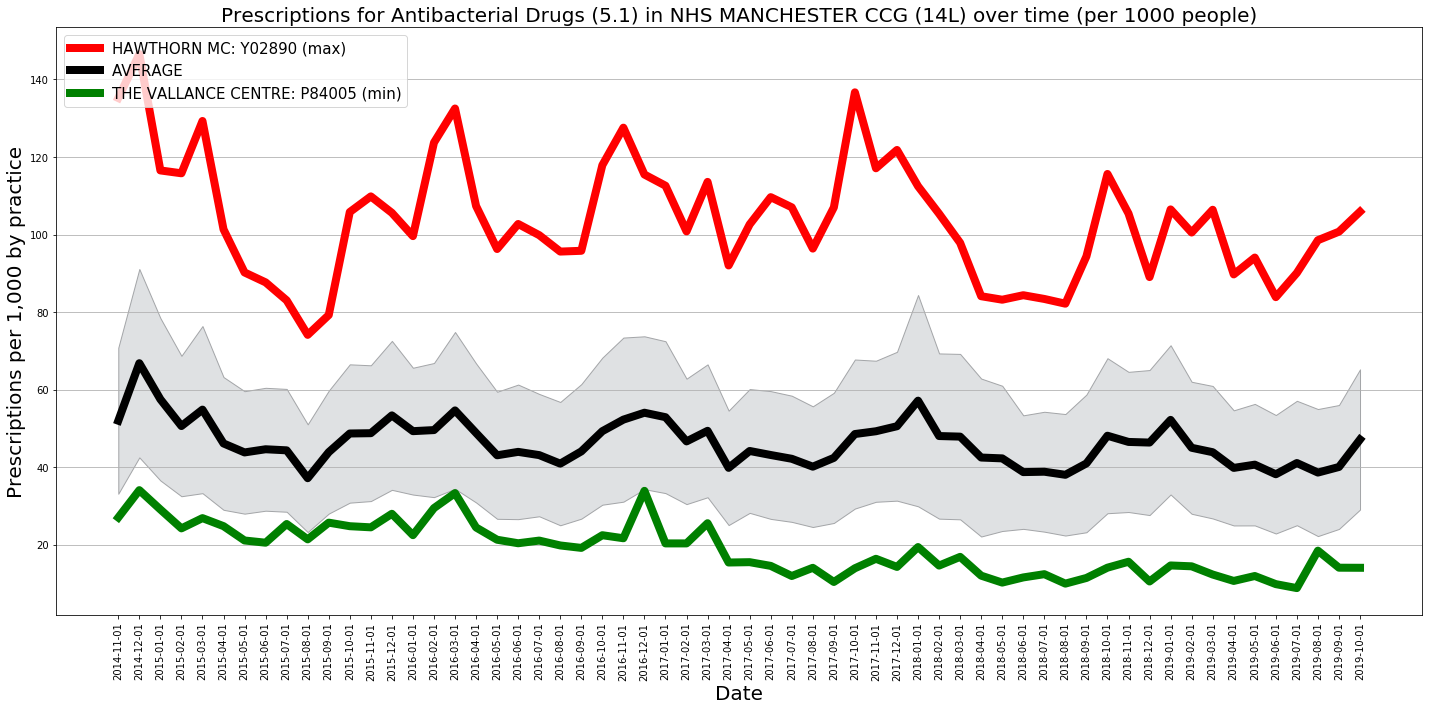

In [54]:
prescriptionsPlot(demomode=True)

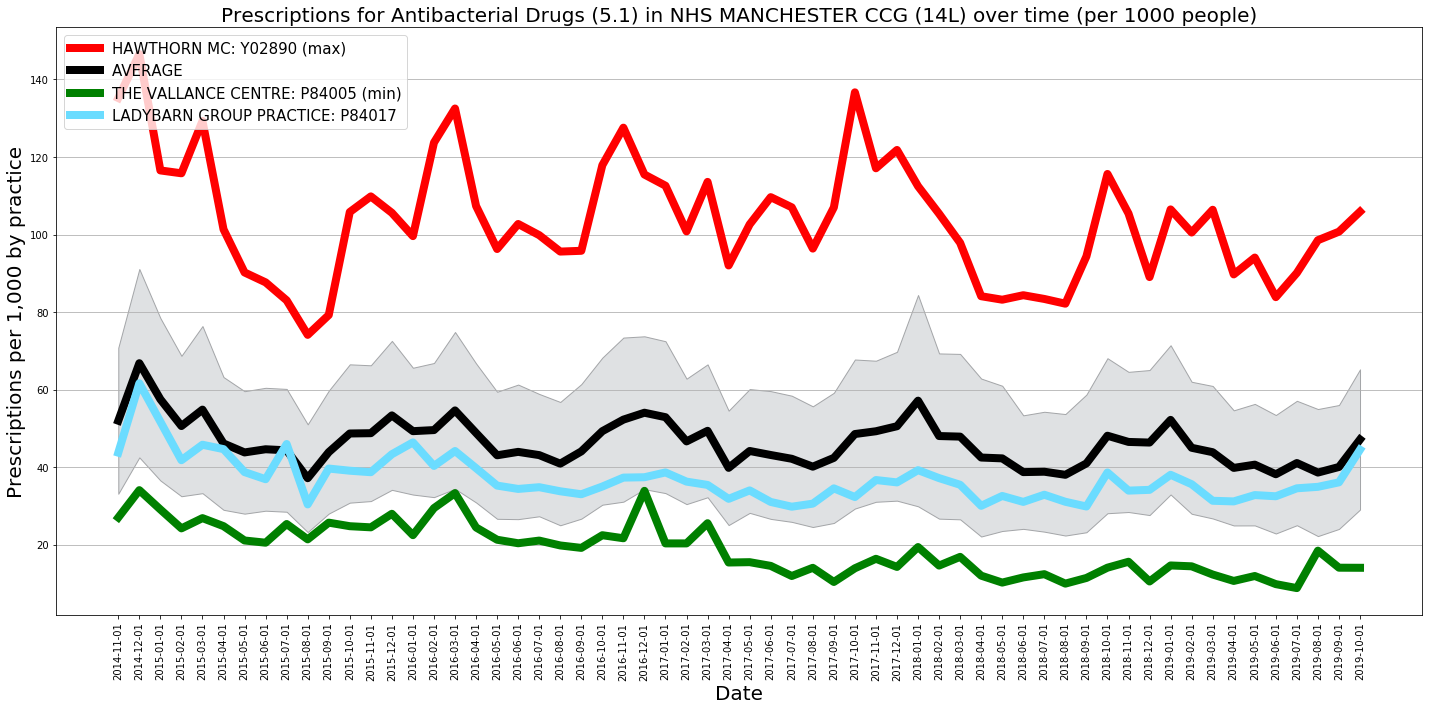

In [55]:
prescriptionsPlot(demomode=True, centre='lady')

### 5) Running the function searching the API for the Manchester CCG and Antibacterial Drugs BNF using their codes.

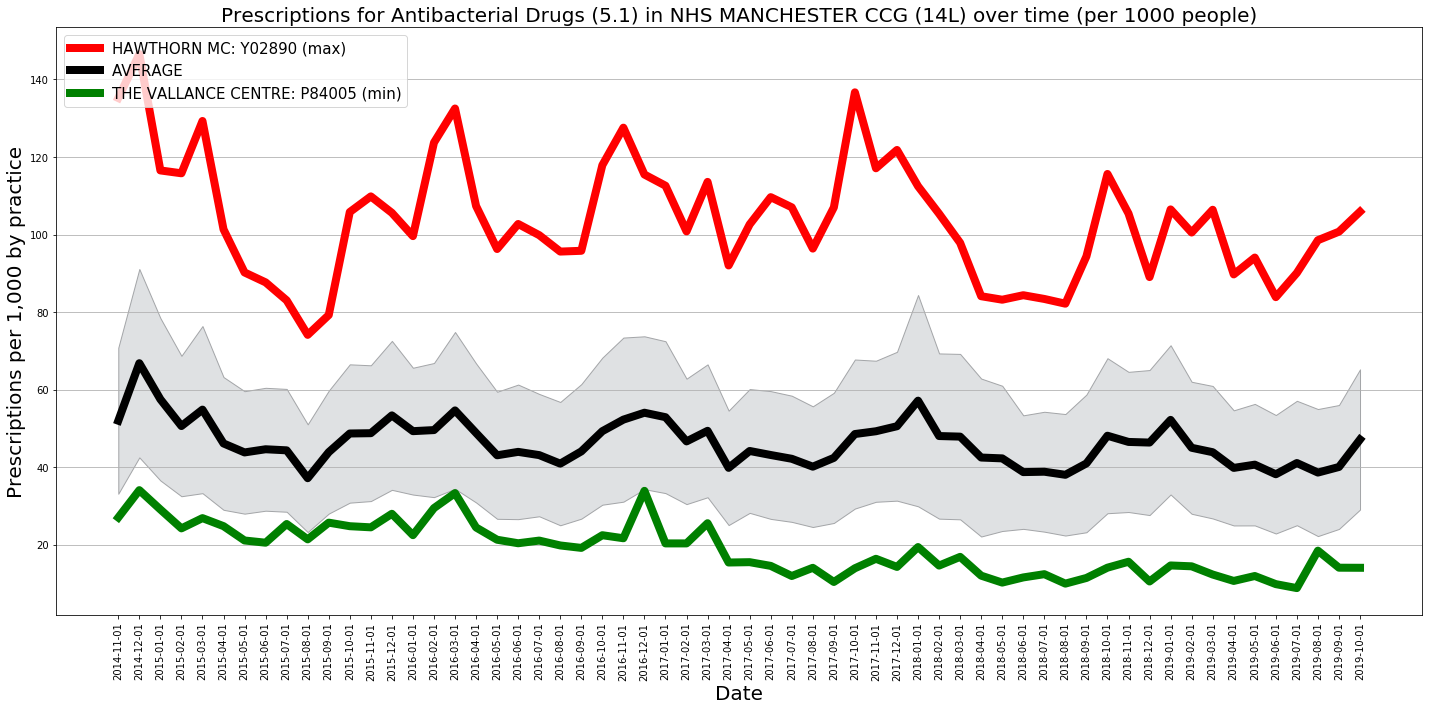

In [26]:
prescriptionsPlot(CCG='14L', BNF='5.1')

*Here can see plot showing the average values and standard deviation pertaining to the number of antibacterial drugs prescribed each month across all centers within the NHS Manchester CCG. Additionally the plot automatically includes the relevent values for the two centres within the selected CCG with the most extreme average values.* 

### 6) Running the function searching the API for the Manchester CCG and Antibacterial Drugs BNF using automatic partial matching of their names.

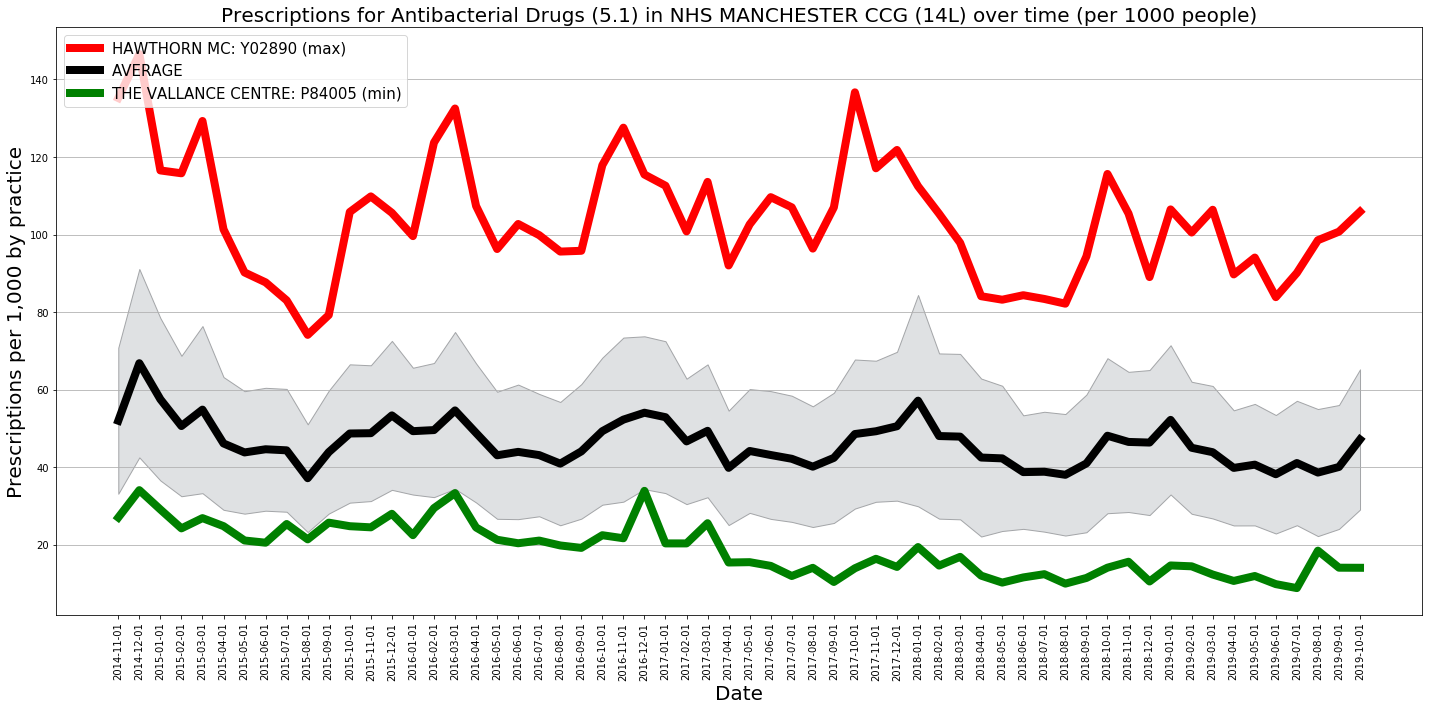

In [10]:
prescriptionsPlot(CCG='manc', BNF='antibacterial drugs')

*Here can see that the function includes intelligent partial match API searching to allow it to be used without a knowlege of specific codes. This call produces exactly the same plot as the one above, produced using codes.*

### 7) Adding the values pertaining to a specific centre to a plot. 

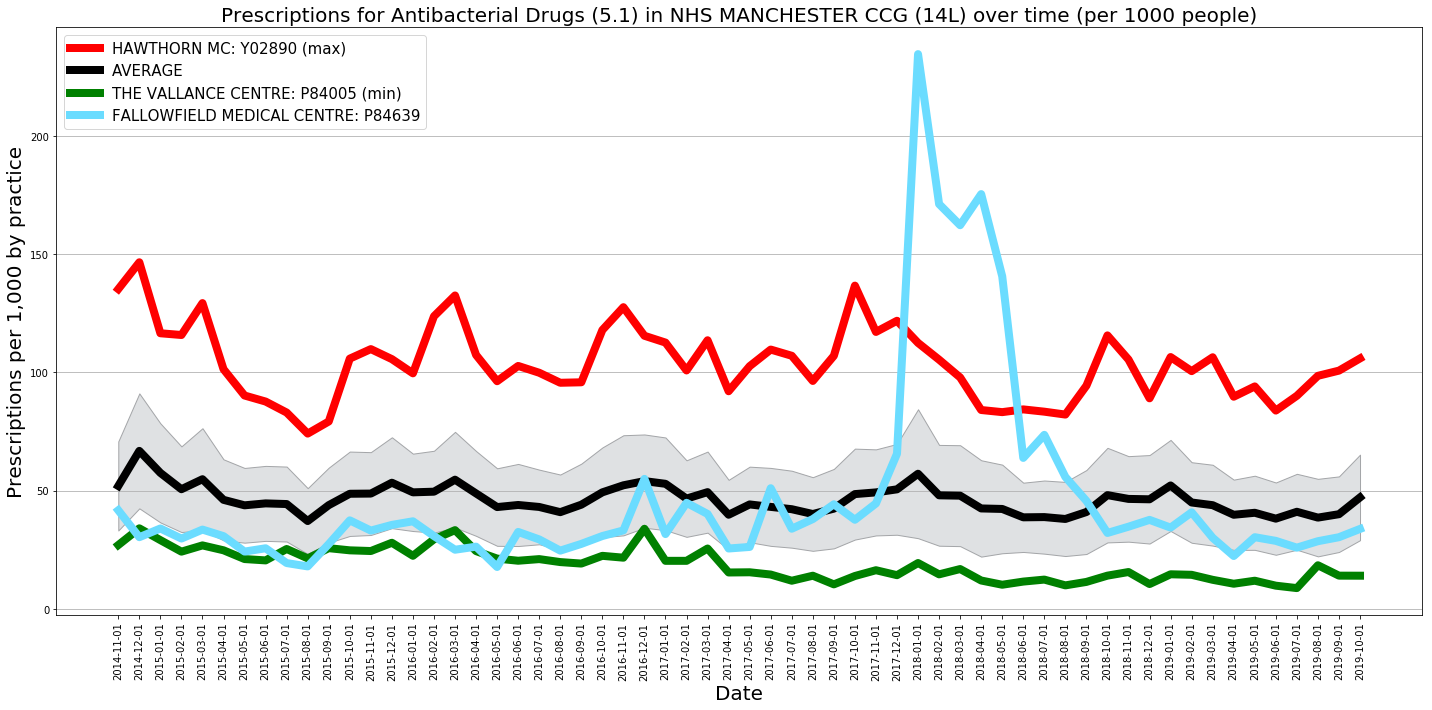

In [11]:
prescriptionsPlot(CCG='manc', BNF='antibacterial drugs', centre='fallowfield')

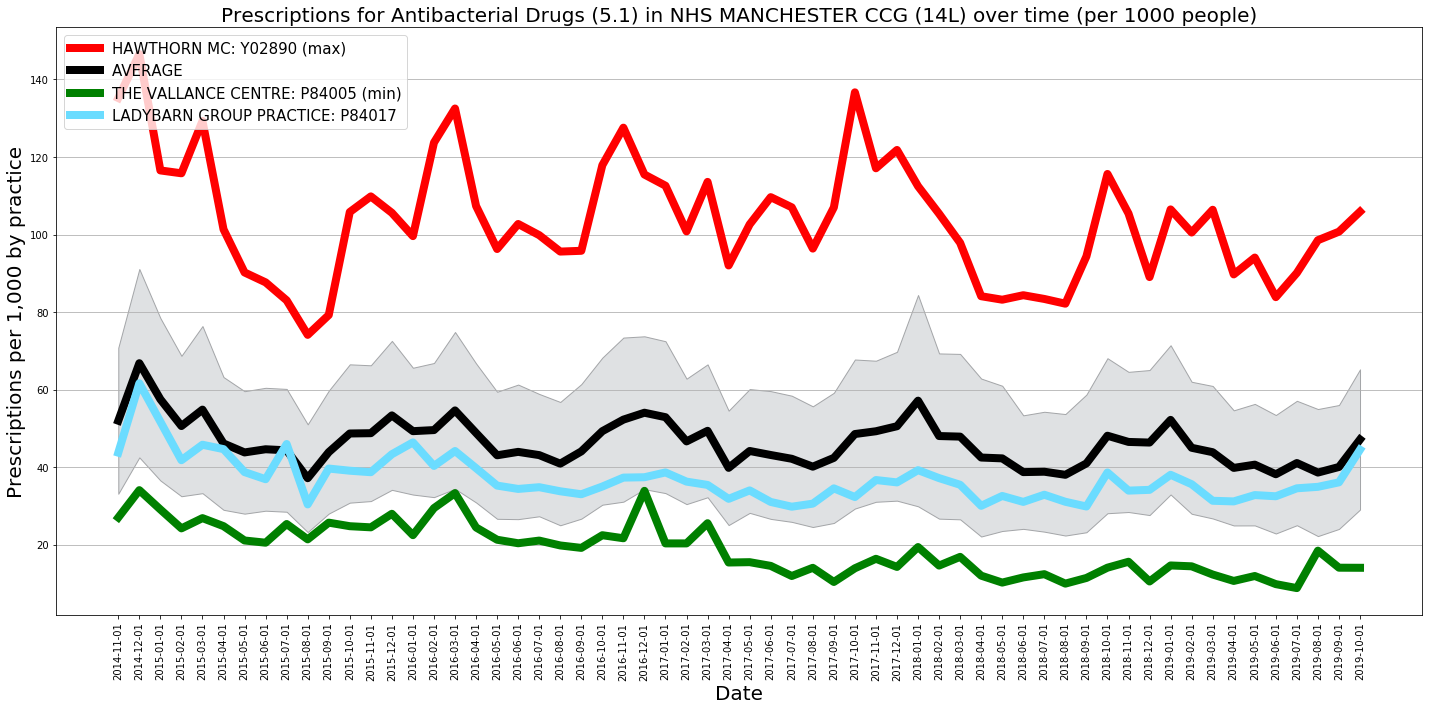

In [12]:
prescriptionsPlot(CCG='manc', BNF='antibacterial drugs', centre='lady')

*The two plots above demonstrate that specifying a centre to the function will add the relevent values for the centre within the selected CCG closest to the search term provided.* 

### 8) Searching for a centre that does not exist within selected CCG.

Invalid centre selection!


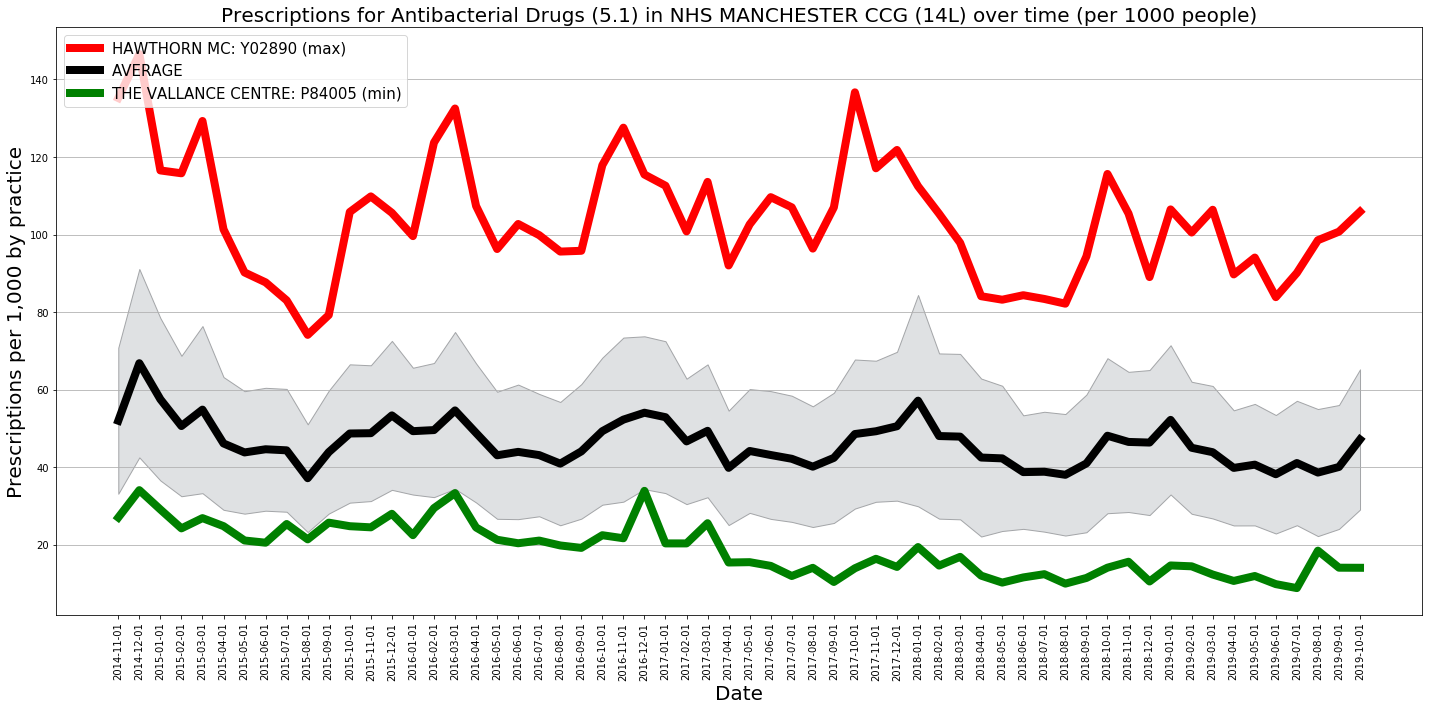

In [13]:
prescriptionsPlot(CCG='manc', BNF='antibacterial drugs', centre='ladywood')

*If no match exists for the specified centre within the selected CCG, the function returns a warning message exaplaining that an invalid entry was provided. It then returns the standard plot showing only the max and min centres as well as the average and standard deviation across all centres.*

### 9) Other examples of the function (different CCG, different BNF, etc.)

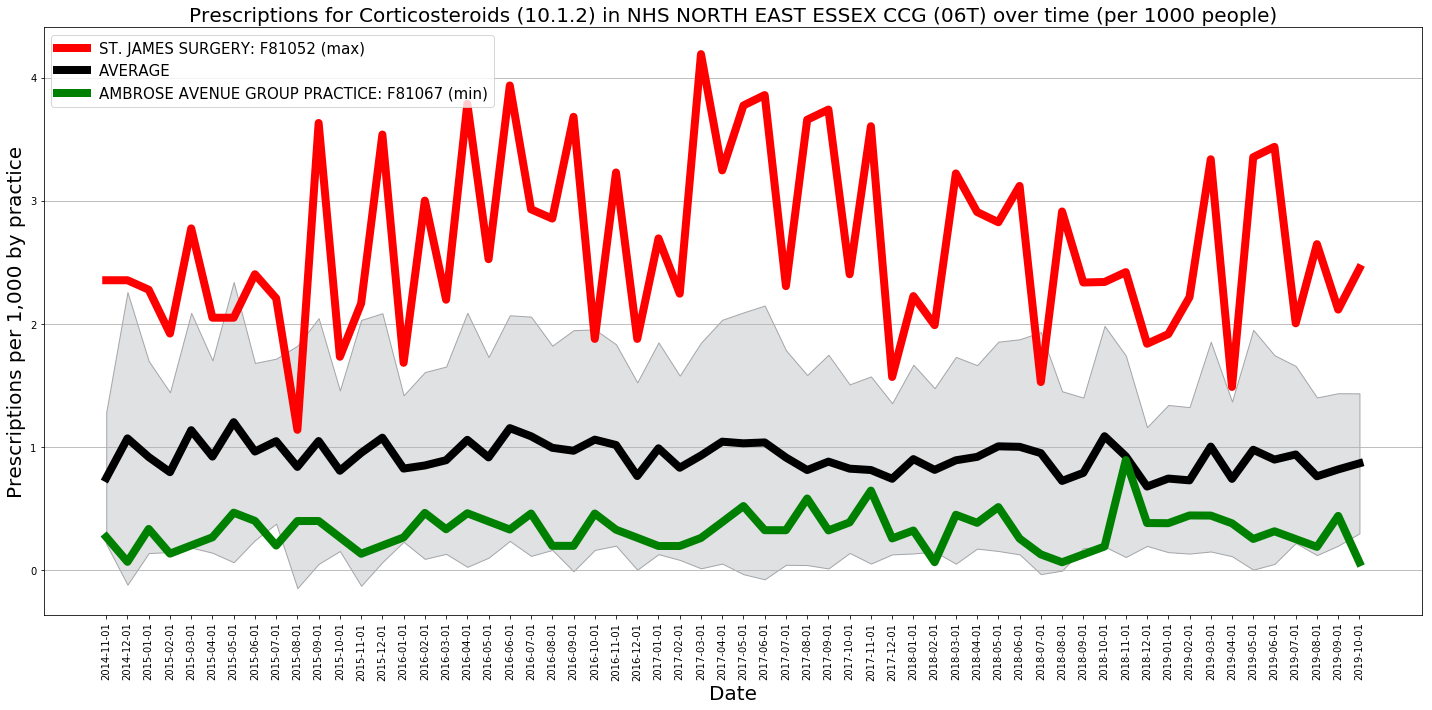

In [14]:
prescriptionsPlot(CCG='essex', BNF='steroids')

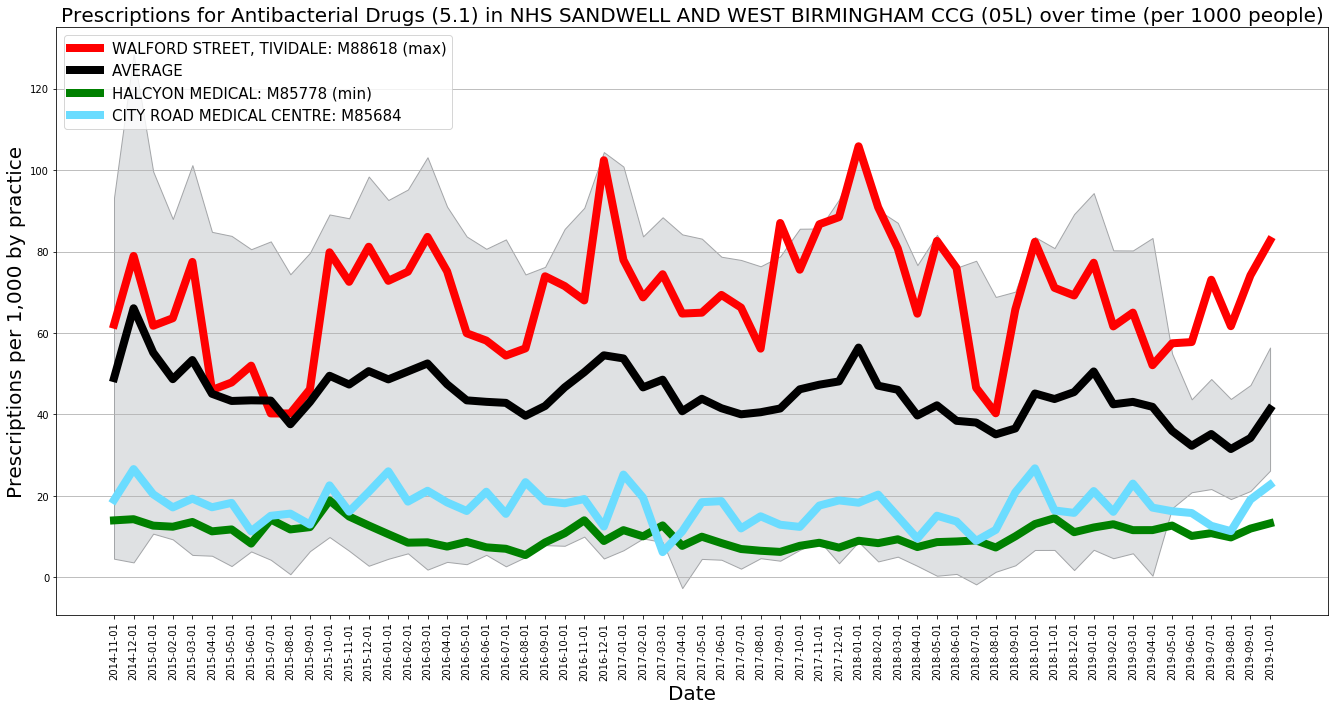

In [15]:
prescriptionsPlot(CCG='birmingham', BNF='5.1', centre='city')